In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.05),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (2*x*(h1))-2
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (2 * x * (h2))-(4 * h1)

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (2*x*(h3))-(6*h2)
    
def softsign(x):
    return x / (1 + tf.abs(x))


class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

# Configure the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Reduce the learning rate by multiplying it by this factor
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,      # The lower bound on the learning rate
    verbose=1            # Print a message when the callback takes action
)




2024-02-26 13:07:02.475149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 13:07:03.000900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

class ResNetHermiteBlock(layers.Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super(ResNetHermiteBlock, self).__init__(**kwargs)
        self.stride = stride
        self.filters = filters
        
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        self.h3 = H3Layer()
        self.h4 = H4Layer()
        
        # Initialize Convolutional and Batch Normalization layers
        self.conv1 = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)
        # self.bn1 = layers.BatchNormalization()
        self.tensorDecomp = TensorDecompositionLayer(3)
        self.conv2 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv3 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv4 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        # self.bn2 = layers.BatchNormalization()

        # Pre-instantiate the Conv2D layer for shortcut adjustment
        self.shortcut_conv = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
        self.shortcut_bn = layers.BatchNormalization()

    def call(self, inputs):
        x = inputs
        
        x = self.conv1(x)
        x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
        x = self.conv2(x)
        x = self.tensorDecomp(x)
        x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        x = self.conv3(x)
        x = self.tensorDecomp(x)
        x = x_h3 = self.h3(x, x_h1,x_h2)  # Pass x_h1 as the additional argument to H2Layer
        x = self.conv4(x)
        x = self.tensorDecomp(x)
        # x = x_h4 = self.h4(x, x_h2,x_h3)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.tensorDecomp(x)
        
        # Conditional application for shortcut
        if self.stride != 1 or inputs.shape[-1] != self.filters:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut)
        else:
            shortcut = inputs

        x += shortcut
        return x  # Note: You might apply another Hermite activation here if needed

def build_resnet18_hermite(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    # x = H1Layer()(x)  # Starting with an H1 Hermite activation
    # x = layers.ReLU()(x)
    
    # Adding ResNetHermiteBlocks
    x = ResNetHermiteBlock(16, stride=1)(x)
    x = ResNetHermiteBlock(32, stride=1)(x)
    x = ResNetHermiteBlock(64, stride=2)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(256, stride=2)(x)
    # x = ResNetHermiteBlock(256, stride=1)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = build_resnet18_hermite((32, 32, 3), 10)
model.summary()

2024-02-26 13:07:03.708794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 13:07:03.730232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 13:07:03.730421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 res_net_hermite_block (Res  (None, 32, 32, 16)        17328     
 NetHermiteBlock)                                                
                                                                 
 res_net_hermite_block_1 (R  (None, 32, 32, 32)        33120     
 esNetHermiteBlock)                                              
                                                             

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])


Epoch 1/100


2024-02-26 13:07:08.951060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-26 13:07:09.814293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-26 13:07:09.816399: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d36e800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 13:07:09.816429: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-26 13:07:09.822522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-26 13:07:09.924072: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 23s 20ms/step - loss: 1.8552 - accuracy: 0.3051 - val_loss: 3.7324 - val_accuracy: 0.1488
Epoch 2/100
782/782 [==============================] - 14s 18ms/step - loss: 1.6791 - accuracy: 0.3820 - val_loss: 1.7268 - val_accuracy: 0.3606
Epoch 3/100
782/782 [==============================] - 14s 18ms/step - loss: 1.5654 - accuracy: 0.4282 - val_loss: 1.9661 - val_accuracy: 0.3337
Epoch 4/100
782/782 [==============================] - 14s 18ms/step - loss: 1.8144 - accuracy: 0.3697 - val_loss: 1.8699 - val_accuracy: 0.3238
Epoch 5/100
782/782 [==============================] - 14s 17ms/step - loss: 1.6283 - accuracy: 0.4041 - val_loss: 2.0072 - val_accuracy: 0.3147
Epoch 6/100
782/782 [==============================] - 13s 17ms/step - loss: 1.5748 - accuracy: 0.4225 - val_loss: 2.5806 - val_accuracy: 0.2545
Epoch 7/100
782/782 [==============================] - 13s 17ms/step - loss: 1.6371 - accuracy: 0.3991 - val_loss: 2.1963 - val_accuracy: 0.26

KeyboardInterrupt: 

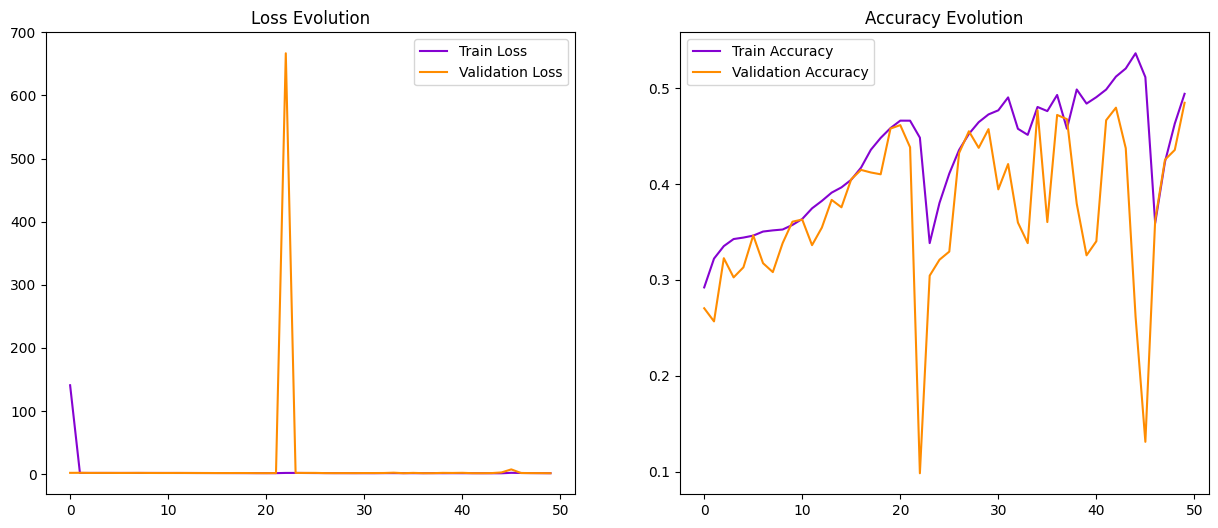

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [ ]:
BatchNormalization
herm1
softsign

NameError: name 'BatchNormalization' is not defined